# Probabilistic matrix factorization for recommendation systems
## Milestone 2 - Preliminary analysis on Movie Lens datasets

*Note: This notebook runs on `Python 3.10.12` and `TensorFlow 2.16.1`. For the full list of packages, please refer to the included `requirements.txt` file.*

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from helper import *

### 1. Introduction

In the age of internet, the amount of resources made available online has increased exponentially every year and is expected to continue to grow. As a result, recommendation systems have become indisposible in helping users navigate the web. We can see the presence of these systems in almost every corner of the internet, from movies and music recommendation of Netflix, Spotify, to post recommendation from social media platforms, search results recommendation by search engines, and even course recommendation on online learning platforms such as Coursera.

One of the earliest class of algorithms for recommendation system is matrix factorization. The idea is quite simple, given a matrix $Y \in \mathbb{R}_{m \times n}$ contains the interactions between users and the available items. $Y$ will contain missing data representing user-item pairs with no interaction. Our goal is to factorize $Y$ into a product of two matrices $C \in \mathbb{R}_{m \times r}$ and $X \in \mathbb{R}_{r \times n}$ in lower dimension ($r \ll m,n$) where $C$ is called the dictionary matrix and $X$ is the matrix of coefficients. Then, we can reconstruct $Y' = CX$ and predict the missing data in $Y$. Early matrix factorization algorithm such as Non-negative Matrix Factorization (NMF) [1][2] has been showed to be effective in recommendation task. However, recent state-of-the-art matrix factorization methods such as Matrix-Variate Gaussian Matrix Factorization (MVGMF) [3] and Dictionary Filter [4] have not yet been studied in this area. Therefore, in this notebook, we would like to take the first step in studying the application of recent state-of-the-art matrix factorization methods on recommendation systems.

### 2. The MovieLens 100k dataset

We will use the Movie Lens dataset [5], which is one of the most popular benchmarks for recommendation systems. This dataset can be accessed from  the `TensorFlow Datasets` package. It comes in a variety of sizes. The recommended version for scientifc research is the MovieLens 25M dataset, containing $25$ million ratings from $162000$ users on $62000$ movies. There is also a small extraction dataset MovieLens 100k containing a subset of $100,000$ ratings. For the purpose of this notebook, we will start with the small MovieLens 100k dataset.

In [3]:
# Load the dataset
ds = tfds.load('movielens/100k-ratings', split='train')

In [16]:
# Print the first 5 examples
tfds.as_dataframe(ds.take(5))

bucketized_user_age movie_genres movie_id  \
0                 45.0          [7]   b'357'   
1                 25.0      [4, 14]   b'709'   
2                 18.0          [4]   b'412'   
3                 50.0       [5, 7]    b'56'   
4                 50.0     [10, 16]   b'895'   

                                 movie_title  raw_user_age  timestamp  \
0  b"One Flew Over the Cuckoo's Nest (1975)"          46.0  879024327   
1                b'Strictly Ballroom (1992)'          32.0  875654590   
2             b'Very Brady Sequel, A (1996)'          24.0  882075110   
3                     b'Pulp Fiction (1994)'          50.0  883326919   
4                         b'Scream 2 (1997)'          55.0  891409199   

   user_gender user_id  user_occupation_label user_occupation_text  \
0         True  b'138'                      4            b'doctor'   
1         True   b'92'                      5     b'entertainment'   
2         True  b'301'                     17           b'student'   
3         True   b'60'                      4        b'healthcare'   
4         True  b'197'                     18        b'technician'   

   user_rating user_zip_code  
0          4.0      b'53211'  
1          2.0      b'80525'  
2          4.0      b'55439'  
3          4.0      b'06472'  
4          3.0      b'75094'

The dataset contains many features, including the user identifiers, the movie identifiers and the ratings. It also contains other metadata such as the user age groups, their occupation, gender, zip codes, and movie genres. However, because we are interested specifically in matrix factorization methods, we will only consider the aforementioned three features: User ids, Movie ids, and Ratings.

In [4]:
# Create a pandas dataframe
df = tfds.as_dataframe(ds)

# Extract the user id, movie id, and rating
df = df[['movie_id', 'user_id', 'user_rating']]

# Convert the movie id and user id to integers
df['movie_id'] = pd.to_numeric(df['movie_id'])
df['movie_id'] = df['movie_id'] - 1
df['user_id'] = pd.to_numeric(df['user_id'])
df['user_id'] = df['user_id'] - 1

# Rename the columns
df.rename(columns={'user_rating': 'Rating', 'movie_id': 'Movie Index', 'user_id': 'User Index'}, inplace=True)

# Display the dataframe
df.head()

Movie Index  User Index  Rating
0          356         137     4.0
1          708          91     2.0
2          411         300     4.0
3           55          59     4.0
4          894         196     3.0

In [5]:
num_unique_movies = len(df['Movie Index'].unique())
num_unique_users = len(df['User Index'].unique())
matrix_density = df.shape[0] / (num_unique_movies * num_unique_users)
print("Number of unique movie ids:", num_unique_movies)
print("Number of unique user ids:", num_unique_users)
print("Matrix density:", matrix_density)

Number of unique movie ids: 1682
Number of unique user ids: 943
Matrix density: 0.06304669364224531


We observate there are $1682$ unique movie ids and $943$ unique user ids. Then, we can compute that the density of our input matrix $Y$ is around $0.063$. Thus, this matrix is very sparse, with more than $93\%$ of the entries missing.

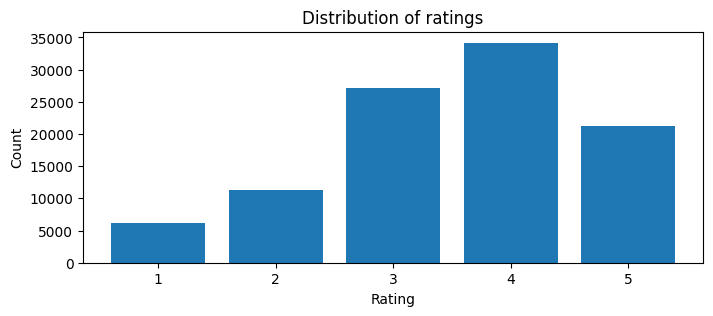

In [6]:
plt.figure(figsize=(8, 3))
rating_counts = df['Rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

We also observe a bell curve over the distribution of ratings.

### 3. Matrix factorization

Next, we would like to try three matrix factorization algorithms on the MovieLens 100k dataset.

For preprocessing, we split the input dataset to $75\%-25\%$ train-test datasets. Then, we transform the datasets into Sparse Tensor matrices of dimensions $m \times n$ where $m$ is the number of movies and $n$ is the number of users.

In [7]:
# Split the dataset into train and test data
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (75000, 3)
Test data shape: (25000, 3)


In [8]:
# Set constants
NUM_MOVIES = df['Movie Index'].max() + 1
NUM_USERS = df['User Index'].max() + 1

In [9]:
# Convert train_data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

#### 3.1 Non-negative Matrix Factorization (NMF)

The first algorithm we test is the Non-negative Matrix Factorization (NMF) algorithm [1][2]. This is arguably one of the first and still remains one of the most popular matrix factorization methods. The algorithm is iterative and the results are deterministic. For MovieLens 100k, we obtain the best results by running the algorithm for $500$ iterations with latent dimension $r = 2$. We choose the normalized mean squared error (NMSE) as the performance metric. This is a popular metric for evaluating matrix factorization algorithms.

In [10]:
# Initialize constants
NUM_FACTORS = 2
INIT_SCALE = df['Rating'].mean() / NUM_FACTORS
NUM_EPOCHS = 500

# Train the NMF model
nmf_train_nmse, nmf_test_nmse = fit_nmf(
    num_movies=NUM_MOVIES, num_users=NUM_USERS, num_factors=NUM_FACTORS, 
    init_scale=INIT_SCALE, num_epochs=NUM_EPOCHS, 
    train_sparse_tensor=train_sparse_tensor, test_sparse_tensor=test_sparse_tensor)

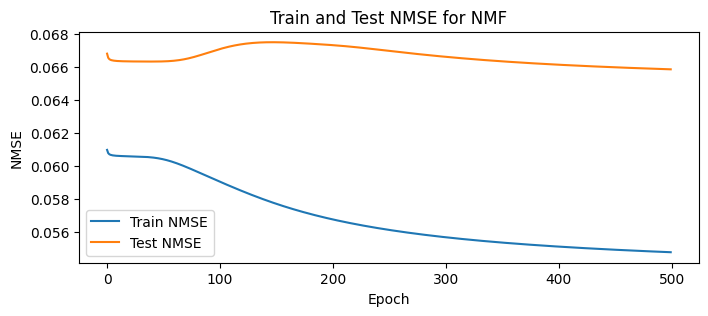

In [11]:
plt.figure(figsize=(8, 3))
plt.plot(nmf_train_nmse, label='Train NMSE')
plt.plot(nmf_test_nmse, label='Test NMSE')
plt.title('Train and Test NMSE for NMF')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

The algorithm achieved a final test NMSE of $0.066$.

#### 3.2 Matrix-Variate Gaussian Matrix Factorization (MVGMF)

Next, we will consider a more recent matrix factorization algorithm: Matrix-Variate Gaussian Matrix Factorization (MVGMF) [3]. This is a probabilistic method. It assumes the distribution of $Y$ is Gaussian given $C$ and $X$. Thus, we can model the likelihood of $Y$ given $C$, $X$: $p(Y|C, X) = \mathcal{MN}(Y; CX, \sigma I_m, \sigma I_n)$ where $\mathcal{MN}$ is the matrix normal distribution, $I_m, I_n$ are identity matrices, and $\sigma \in \mathbb{R}$ is the variance. Intuitively, the usage of Gaussian distribution makes sense given the distribution of ratings we observe earlier. For the best results, we run the algorithm for $200$ iterations with $r = 4$, $\sigma = 0.2$ and the prior initialization factor $k=40$. 

In [12]:
# Initialize constants
NUM_FACTORS = 4
INIT_SCALE = df['Rating'].mean() / NUM_FACTORS
K = 40
SIGMA = 0.2
NUM_EPOCHS = 200

# Train the MVGMF model
mvgmf_train_nmse, mvgmf_test_nmse = fit_mvgmf(
    num_movies=NUM_MOVIES, num_users=NUM_USERS, num_factors=NUM_FACTORS, 
    init_scale=INIT_SCALE, k=K, sigma=SIGMA, num_epochs=NUM_EPOCHS, 
    train_sparse_tensor=train_sparse_tensor, test_sparse_tensor=test_sparse_tensor)

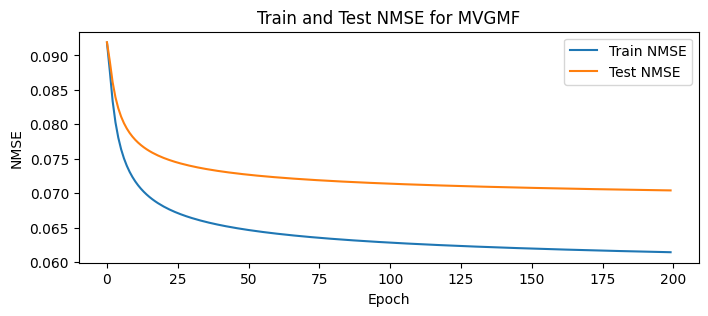

In [13]:
plt.figure(figsize=(8, 3))
plt.plot(mvgmf_train_nmse, label='Train NMSE')
plt.plot(mvgmf_test_nmse, label='Test NMSE')
plt.title('Train and Test NMSE for MVGMF')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.legend()
plt.show()

Although the resulted test NMSE of $0.070$ is slightly higher than that of NMF, it is very close. We can say that these two algorithms performed similarly on this dataset. 

#### 3.3 Dictionary Filter (DF)

In the previous algorithms, the matrix updates for each iteration have been done on the whole dataset. They include matrix multiplication and inversion involving $Y$ or matrices of the similar size. Thus, they require an infeasible amount of memory to operate on large dataset such as MovieLens 25M where the full matrix $Y$ would have size $162000 \times 62000$.

Therefore, we would like to take a look at the Dictionary Filter (DF) [4] algorithm. It employs a similar probabilistic model to MVGMF above; however, it updates the dictionary matrix $C$ using one row $y_k$ from the input matrix $Y$ at a time. Thus, we can apply this matrix factorization method on large datasets. For the MovieLens 100k dataset, we found the best result by running the algorithm for $20$ iterations with $r=2$ and the training parameter $\lambda = 2.0$.

In [14]:
# Initialize constants
NUM_FACTORS = 2
INIT_SCALE = df['Rating'].mean() / NUM_FACTORS
TRAIN_LAMBDA = 2.0
NUM_EPOCHS = 20

# Train the DF model
df_train_nmse, df_test_nmse = fit_df(
    num_movies=NUM_MOVIES, num_users=NUM_USERS, num_factors=NUM_FACTORS, 
    init_scale=INIT_SCALE, train_lambda=TRAIN_LAMBDA, num_epochs=NUM_EPOCHS, 
    train_sparse_tensor=train_sparse_tensor, test_sparse_tensor=test_sparse_tensor)

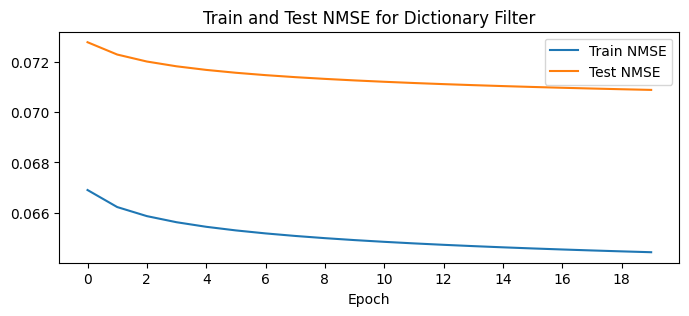

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(df_train_nmse, label='Train NMSE')
plt.plot(df_test_nmse, label='Test NMSE')
plt.title('Train and Test NMSE for Dictionary Filter')
plt.xlabel('Epoch')
plt.xticks(range(0, NUM_EPOCHS, 2))
plt.legend()
plt.show()

We observe that DF has similar performance comparing to the previous methods, obtaining a test NMSE of $0.070$.

### 4. Conclusion and future directions

In conclusion, we observe that the input matrices representing the recommendation system benchmark datasets are often very sparse and large. For example, the matrix representing the MovieLens 25M dataset would have size $62000 \times 162000$ with $25$ millions rating. This works out to a density of only $0.0025$. We also observe that the Dictionary Filter algorthm performed similarly comparing to the Non-negative Matrix Factorization and the Matrix-Variate Gaussian Matrix Factorization methods on the MovieLens 100k dataset. Thus, we should be able to apply DF on the larger MovieLens dataset.

For the next steps, we have three directions:

- We can apply Dictionary Filter on the full recommendation system benchmark datasets. Beside MovieLens 25M, the Netflix Prize dataset [7] and the Million Song dataset [8] are both also very popular for recommendation system benchmark. We may also want to optimize the performance of Dictionary Filter in order to reduce training time. Currently, the algorithm update uses single observations. We may be able to improve this algorithm by doing batch updates instead.

- We can use a more practical train-test split and performance metrics. In this notebook, we split the train and test dataset by ratings. However, in practice, we want the algorithms to provide recommendations to new users. Thus, we should split the train-test dataset by users instead, where part of the ratings from users in the test dataset are withhold to evaluate the model predictions. Furthermore, in practice, the goal of recommendation systems is not to predict user ratings, but to find items that users would likely give high ratings. Thus, NMSE may not be the most suitable metric. We can consider other metrics such as recall or precision at top $20$ predicted ratings instead.

- We can modify DF to work with binary matrices. In practice, we often don't have a dataset of user ratings. Instead, we may have a binary dataset of $0$ and $1$ indicating whether a user interacted with a particular item. In this case, it may be more suitable to modify the the likelihood function of $Y$ give $C$ and $X$ of DF to Bernoulli distribution instead of Gaussian distribution. There are several popular benchmark binary datasets for recommendation systems we can test on such as the Amazon book dataset, the Gowala dataset, and the Yelp 2018 dataset [6].

### 5. References

[1] 	Lee, D.D. & Seung, H.S. 1999, Learning the parts of objects by non-negative matrix factorization, Springer Science and Business Media LLC.\
[2] 	Lee, D. & Seung, H.S. 2000, "Algorithms for non-negative matrix factorization", Advances in neural information processing systems, vol. 13.\
[3] 	Maletta, R. 2023, Matrix-Variate Gaussian Matrix Factorisation, Imperial College London.\
[4] 	Akyildiz, ÖD. & Míguez, J. 2018, Dictionary filtering: a probabilistic approach to online matrix factorisation, Springer Science and Business Media LLC.\
[5] 	Harper, F.M. & Konstan, J.A. 2015, "The movielens datasets: History and context", Acm transactions on interactive intelligent systems (tiis), vol. 5, no. 4, pp. 1-19. \
[6] 	He, X., Deng, K., Wang, X., Li, Y., Zhang, Y. & Wang, M. 2020, LightGCN, ACM. \
[7] 	Bennett, J. & Lanning, S. 2007, "The netflix prize", Proceedings of KDD cup and workshopNew York, , pp. 35. \
[8] 	Bertin-Mahieux, T., Ellis, D.P., Whitman, B. & Lamere, P. 2011, "The million song dataset",.